In [1]:
from qiskit import QuantumRegister, QuantumCircuit
import matplotlib

In [6]:
from qiskit_ibm_provider import IBMProvider
# IBMProvider.save_account('73b58acb434c1280ad3d67d714c2ae81fe2141182cae419ad4e86eb10f4e8cced4c288f67b08954a6735678baad82485d6e3528e51666702bd81c9d17b935dd7')
provider = IBMProvider()
provider.active_account()
# IBMProvider.delete_account()

{'channel': 'ibm_quantum',
 'token': '73b58acb434c1280ad3d67d714c2ae81fe2141182cae419ad4e86eb10f4e8cced4c288f67b08954a6735678baad82485d6e3528e51666702bd81c9d17b935dd7',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'verify': True,
 'instance': 'ibm-q/open/main'}

D:\Programs\Anaconda3\envs\qiskitenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


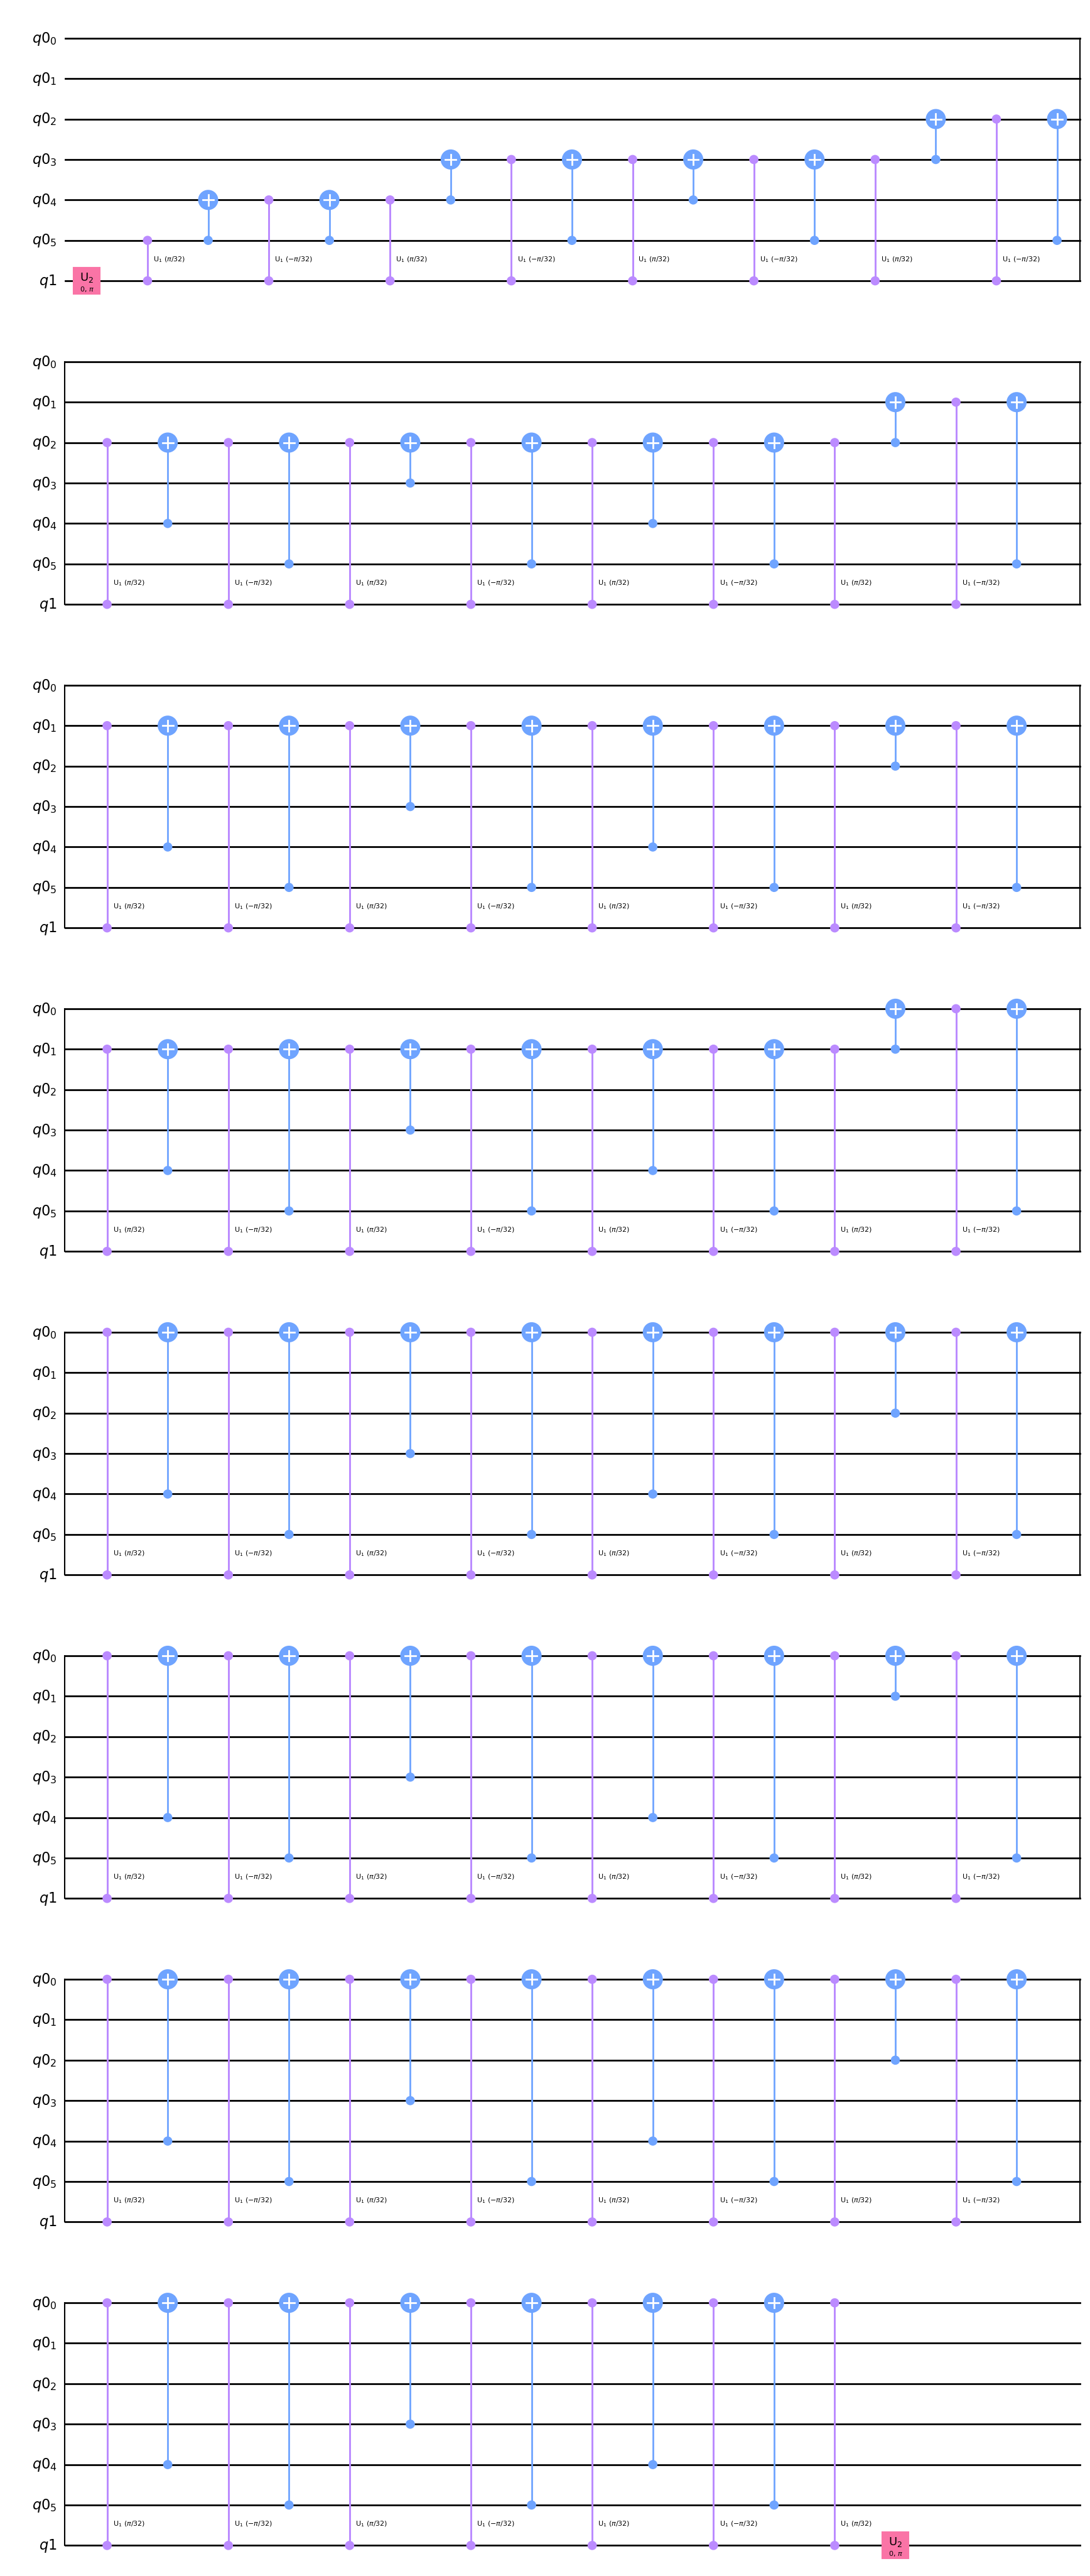

In [2]:
control = QuantumRegister(6)
target = QuantumRegister(1)
qc = QuantumCircuit(control, target)
qc.mcx(control, target[0])
qc.decompose().decompose().draw('mpl')

C:\ProgramData\anaconda3\envs\qiskitenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


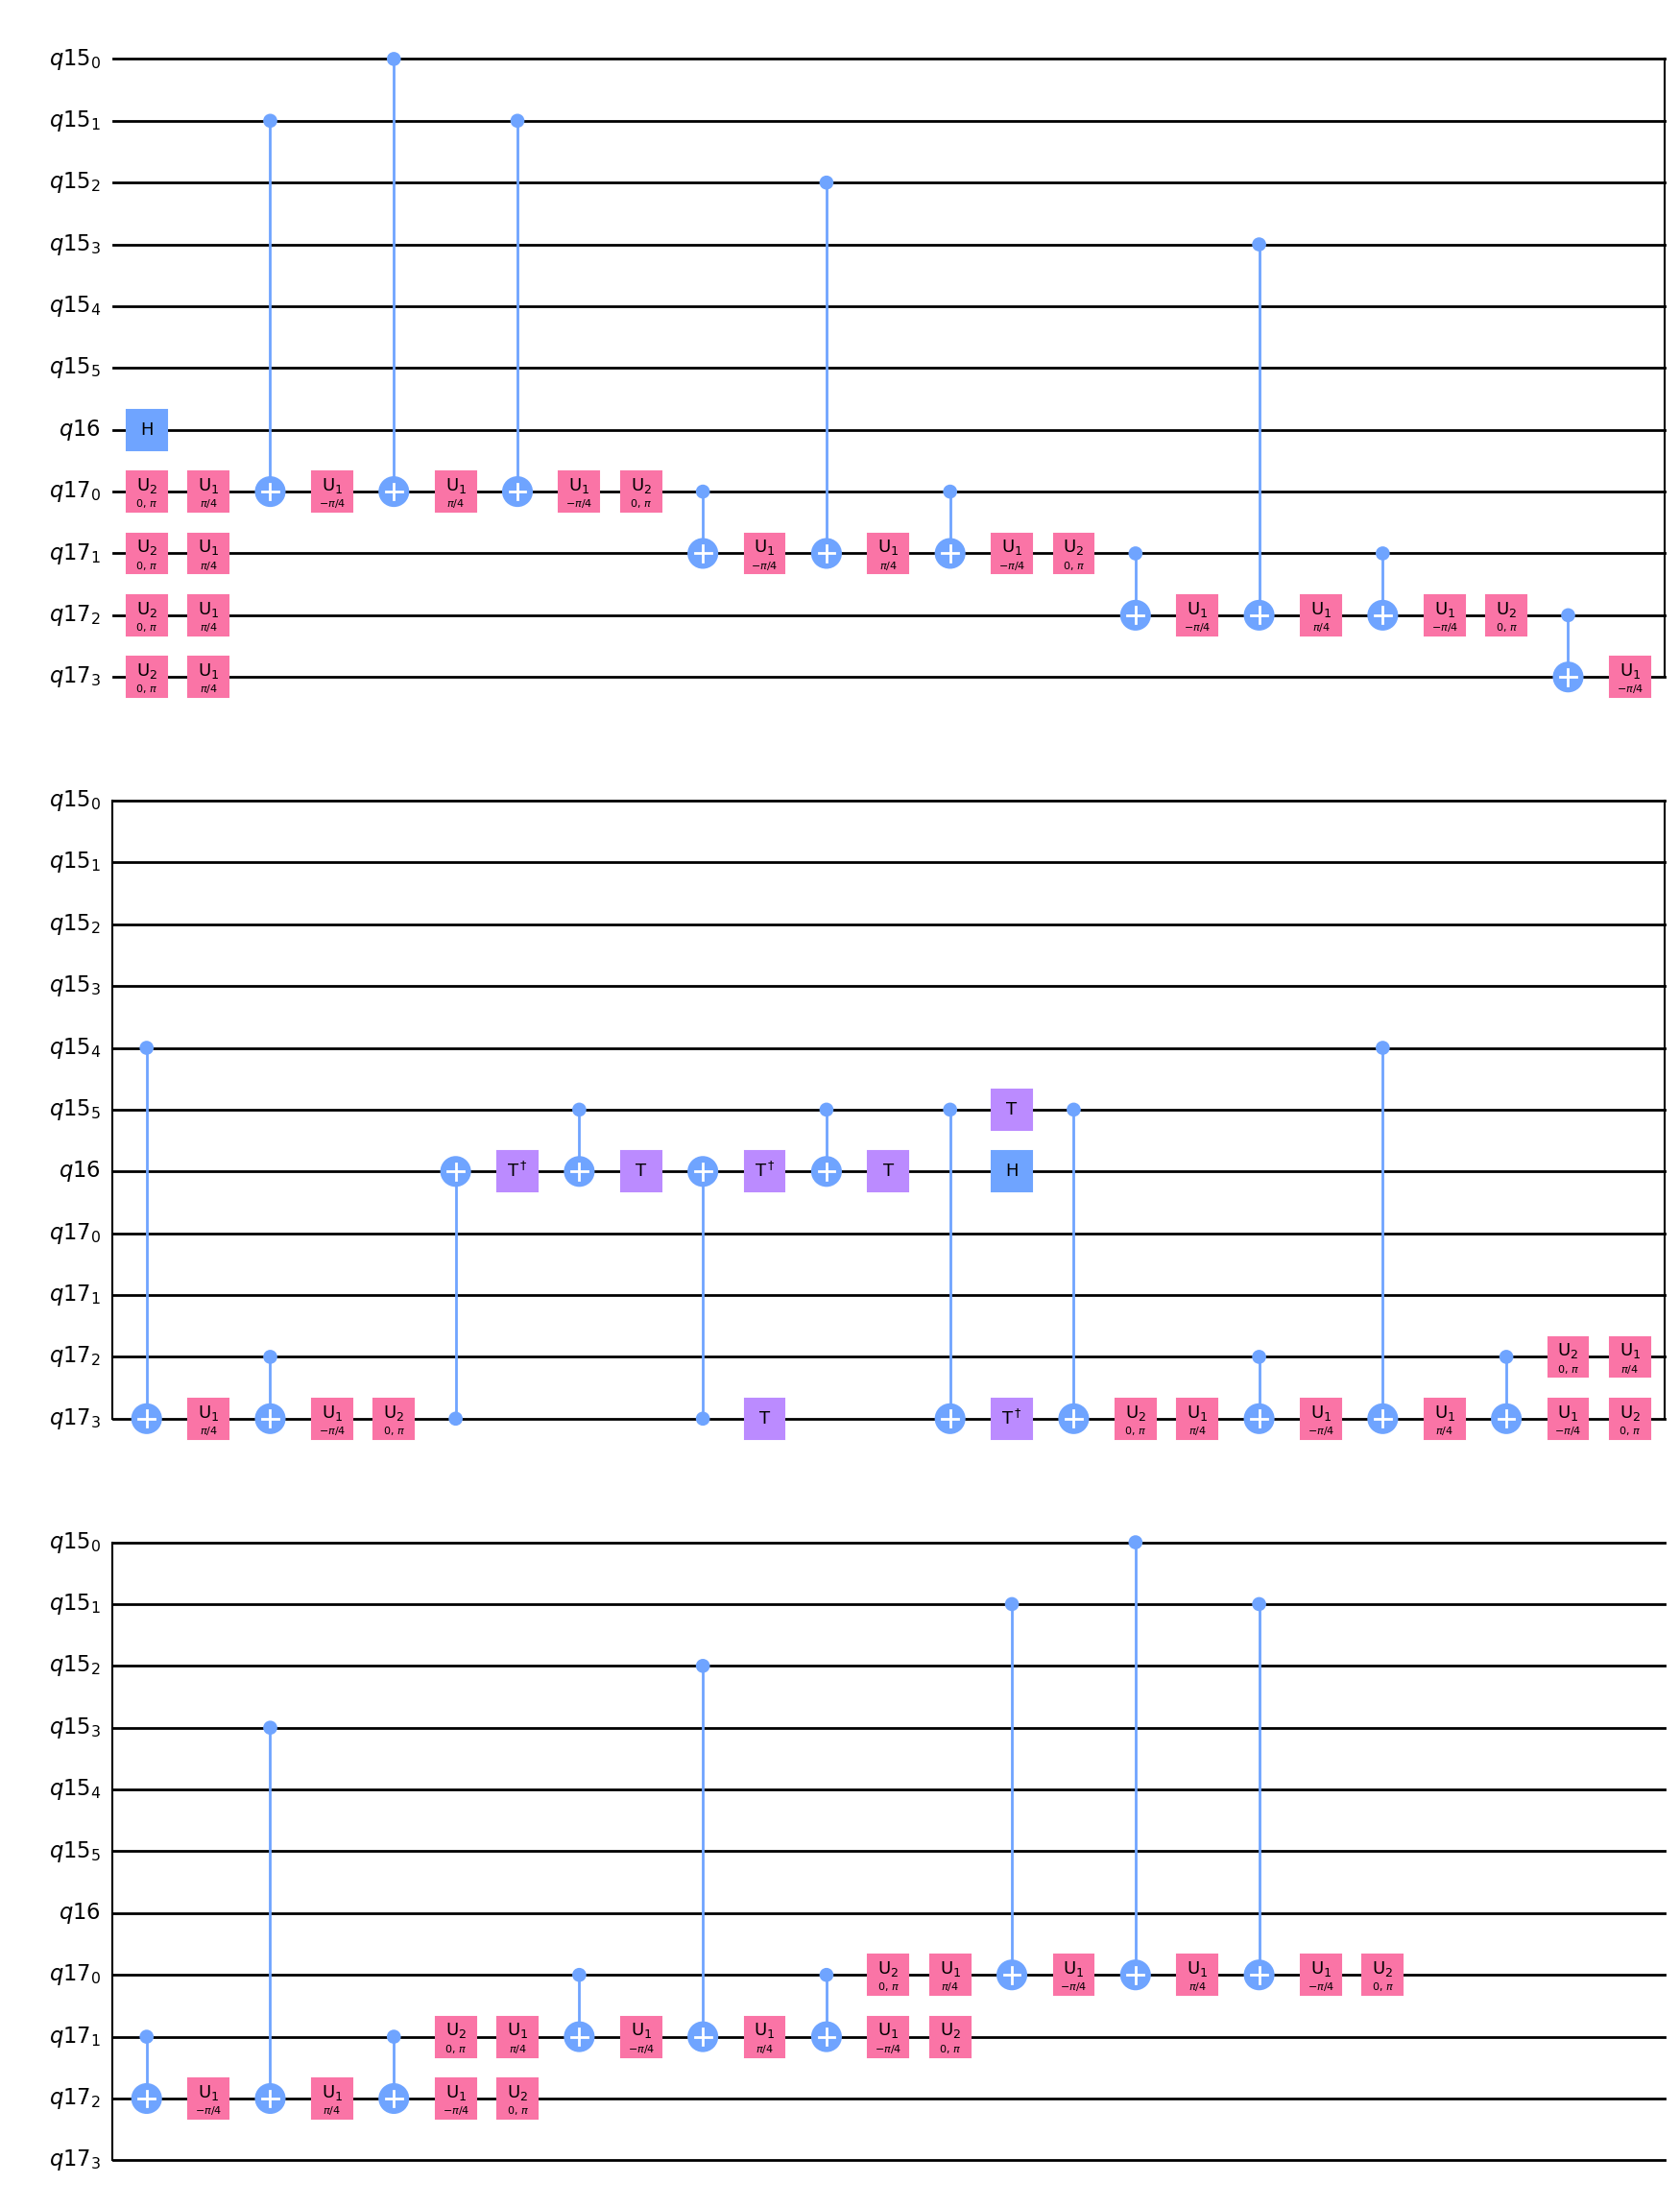

In [8]:
control = QuantumRegister(6)
target = QuantumRegister(1)
anc = QuantumRegister(4)
qc = QuantumCircuit(control, target, anc)
qc.mcx(control, target[0], anc, mode='v-chain')
qc.decompose().decompose().draw('mpl')

In [6]:
from qiskit import QuantumCircuit, Aer, execute
qc = QuantumCircuit(3)
qc.x(0)
qc.measure_all()

backend = Aer.get_backend("qasm_simulator")
job = execute(qc, backend, shots=1)
count = job.result().get_counts()
print(count)
print(list(count)[0])

{'001': 1}
001


In [7]:
import math as m 
print(m.asin(0.00175))

0.0017500008932303977


In [1]:
import numpy as np

# 生成一个5x5的随机数组，每个值大于0
positive_random_array = np.random.uniform(0.1, 10.0, (4, 4))

print(positive_random_array)

[[8.71964918 2.68470061 4.01758933 8.83660166]
 [8.36513678 4.57806876 6.91598966 3.04656776]
 [7.05037345 0.47197036 3.08016333 1.6650888 ]
 [9.8323104  4.78825845 6.26700962 0.24171474]]


0.03806023374435662
